In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [28]:
scores = []

In [29]:
#ah
scores.append([0.5555555555555556,
 0.5555555555555556,
 0.25,
 0.4444444444444445,
 0.4444444444444445,
 0.5555555555555556,
 0.5277777777777778,
 0.4444444444444445,
 0.4222222222222222,
 0.3875])

In [30]:
#da
scores.append([0.5416666666666666,
 0.46726190476190477,
 0.38095238095238093,
 0.33333333333333337,
 0.38095238095238093,
 0.3333333333333333,
 0.375,
 0.42261904761904756,
 0.48000000000000004,
 0.5714285714285714])

In [31]:
#dnn
scores.append([0.5,
 0.5,
 0.33333333333333337,
 0.33333333333333337,
 0.33333333333333337,
 0.33333333333333337,
 0.5,
 0.5,
 0.5,
 0.6666666666666666])

In [32]:
#esn
scores.append([0.4520833333333333,
 0.5,
 0.4520833333333333,
 0.5166666666666667,
 0.5,
 0.4375,
 0.4,
 0.5,
 0.4833333333333334,
 0.48333333333333334])

In [33]:
#eva
scores.append([0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666667,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666667,
 0.6666666666666667,
 0.6666666666666666,
 0.6666666666666667])

In [34]:
#fd
scores.append([0.4083333333333333,
 0.5,
 0.5916666666666667,
 0.5,
 0.33333333333333337,
 0.45833333333333337,
 0.4,
 0.41666666666666663,
 0.3666666666666667,
 0.225])

In [35]:
#fit
scores.append([0.41666666666666663,
 0.4,
 0.5416666666666666,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.33333333333333337,
 0.41666666666666663])

In [36]:
#grg
scores.append([0.5327380952380952,
 0.5,
 0.5,
 0.2678571428571429,
 0.45833333333333337,
 0.56,
 0.5219047619047619,
 0.5555555555555556,
 0.5308333333333333,
 0.5486111111111112])

In [37]:
#khm
scores.append([0.6666666666666666,
 0.5833333333333333,
 0.5833333333333333,
 0.5,
 0.5,
 0.5833333333333334,
 0.7,
 0.5,
 0.5833333333333333,
 0.6])

In [38]:
scores.append([0.51,
 0.52,
 0.4691666666666667,
 0.5238095238095238,
 0.5,
 0.5,
 0.3466666666666667,
 0.3666666666666667,
 0.41666666666666663,
 0.375])

In [39]:
#mni
scores.append([0.43333333333333335,
 0.5,
 0.41666666666666674,
 0.3619047619047619,
 0.3333333333333333,
 0.3333333333333333,
 0.375,
 0.4,
 0.375,
 0.4083333333333333])

In [40]:
#mrl
scores.append([0.56125,
 0.5,
 0.52,
 0.5416666666666667,
 0.6011904761904763,
 0.5833333333333334,
 0.625,
 0.5508333333333334,
 0.52,
 0.4491666666666667])

In [41]:
#msf
scores.append([0.48333333333333334,
 0.4666666666666667,
 0.4520833333333333,
 0.2666666666666667,
 0.3875,
 0.41666666666666663,
 0.4,
 0.3541666666666667,
 0.375,
 0.4520833333333333])

In [42]:
#nhm
scores.append([0.4,
 0.45,
 0.4,
 0.4444444444444444,
 0.5555555555555556,
 0.5,
 0.5,
 0.5,
 0.6666666666666666,
 0.6])

In [43]:
#rob
scores.append([0.5833333333333334,
 0.275,
 0.4083333333333333,
 0.5,
 0.5,
 0.5,
 0.31666666666666665,
 0.4083333333333333,
 0.5,
 0.6])

In [44]:
#sby
scores.append([0.4392857142857143,
 0.4742063492063492,
 0.38095238095238093,
 0.5476190476190477,
 0.6464285714285715,
 0.5976190476190476,
 0.6,
 0.5488095238095239,
 0.5851190476190475,
 0.5404761904761904])

In [45]:
#yngy
scores.append([0.6666666666666667,
 0.3333333333333333,
 0.4166666666666667,
 0.25,
 0.5,
 0.5,
 0.5833333333333333,
 0.6666666666666666,
 0.4166666666666667,
 0.6666666666666667])

In [46]:
#ysf
scores.append([0.41666666666666663,
 0.4666666666666666,
 0.5333333333333333,
 0.6000000000000001,
 0.5333333333333333,
 0.6,
 0.5,
 0.4666666666666667,
 0.6,
 0.625])

In [47]:
scores_df = pd.DataFrame(
    data=scores, 
    columns=['7', '18', '30','40','60','70','90','100','110','120Hz'])

In [48]:
accuracies = []
freqs = []
for col in scores_df.columns:
    accuracies = np.concatenate((accuracies, scores_df[col].values))
    freqs += [col] * len(scores_df[col])
# print([accuracies,freqs])
scs = pd.DataFrame(data=list(zip(accuracies,freqs)), columns=['acc','freqs'])

C:\Users\Alberto\AppData\Local\Temp\ipykernel_17308\565276092.py:9: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  median_val = scs[scs['freqs']==sample_name].median()[0]


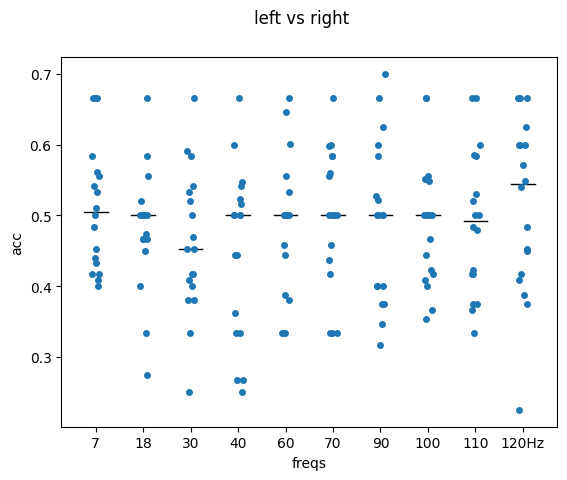

In [51]:
csp_fig, axes = plt.subplots(1)
csp_fig.suptitle('left vs right')
# axes.axhline(.5, c='grey')
sns.stripplot(y='acc', x='freqs', data=scs, ax=axes)
median_width= 0.5
for tick, text in zip(axes.get_xticks(), axes.get_xticklabels()):
    sample_name = text.get_text()  # "X" or "Y"
    # calculate the median value for all replicates of either X or Y
    median_val = scs[scs['freqs']==sample_name].median()[0]
    # plot horizontal lines across the column, centered on the tick
    axes.plot([tick-median_width/2, tick+median_width/2], [median_val, median_val],
            lw=1, color='k')